### Imports

In [1]:
# basic imports
import os, random
import pandas as pd
import numpy as np
import datetime as dt
import pandas_ta as ta
from pathlib import Path
import yfinance as yf
import math
import shap

# import minisom
from minisom import MiniSom

# warnings
import warnings
warnings.filterwarnings('ignore')

# plotting & outputs
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# XGBoost
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay                            
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_curve

# import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
from tensorflow.keras.optimizers.schedules import ExponentialDecay

#from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.optimizers.legacy import Adam, RMSprop 
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy, AUC, Precision, Recall, F1Score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.layers import LSTM, BatchNormalization, Bidirectional, GRU

# kerastuner 
import keras_tuner as kt
from keras_tuner import HyperParameters
from keras_tuner.tuners import RandomSearch, BayesianOptimization, Hyperband

# set display options
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 1000)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# # Machine info & package version
from watermark import watermark
%load_ext watermark
%watermark -a "Siqi He" -u -d -v -m -iv  

Author: Siqi He

Last updated: 2024-01-09

Python implementation: CPython
Python version       : 3.8.18
IPython version      : 8.12.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.0.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib : 3.7.2
pandas     : 1.5.3
tensorflow : 2.13.1
numpy      : 1.22.4
keras_tuner: 1.3.5
pandas_ta  : 0.3.14b0
yfinance   : 0.2.33
shap       : 0.44.0
seaborn    : 0.13.0



### Load data and setting labels

In [2]:
# Data preparation: Load scaled dataframes for training set

# LOAD CSV: raw Y values 
Y_train_df_raw = pd.read_csv("data/Y_train_df_raw.csv",index_col=0)
Y_dev_df_raw = pd.read_csv("data/Y_dev_df_raw.csv",index_col=0)
Y_test_df_raw = pd.read_csv("data/Y_test_df_raw.csv",index_col=0)

# LOAD CSV: Filtered - after removing high-corr
X_train_df_scaled_kmeans_som = pd.read_csv("data/X_train_df_scaled_kmeans_som.csv",index_col=0)
X_dev_df_scaled_kmeans_som = pd.read_csv("data/X_dev_df_scaled_kmeans_som.csv",index_col=0)
X_test_df_scaled_kmeans_som = pd.read_csv("data/X_test_df_scaled_kmeans_som.csv",index_col=0)

# convert data to numpy arrays for XGBoost
X_train_xg = X_train_df_scaled_kmeans_som.to_numpy()
X_dev_xg = X_dev_df_scaled_kmeans_som.to_numpy()
X_test_xg = X_test_df_scaled_kmeans_som.to_numpy()

# Set Y label threshold values
thresh_xg = 0.001
thresh_rf = 0.001

# turn Y raw values into direction labels for XGBoost
y_train_xg = np.where(Y_train_df_raw['label']>thresh_xg, 1, 0)
y_dev_xg = np.where(Y_dev_df_raw['label']>thresh_xg, 1, 0)
y_test_xg = np.where(Y_test_df_raw['label']>thresh_xg, 1, 0)

# convert data to numpy arrays for RandomForest
X_train_rf = X_train_df_scaled_kmeans_som.to_numpy()
X_dev_rf = X_dev_df_scaled_kmeans_som.to_numpy()
X_test_rf = X_test_df_scaled_kmeans_som.to_numpy()

# turn Y raw values into direction labels for RandomForest
y_train_rf = np.where(Y_train_df_raw['label']>thresh_rf, 1, 0)
y_dev_rf = np.where(Y_dev_df_raw['label']>thresh_rf, 1, 0)
y_test_rf = np.where(Y_test_df_raw['label']>thresh_rf, 1, 0)

### Class weights

In [3]:
# Function for computing class weights for a binary label column
def cwts(dfs):
    '''
    Calculates class weights based on target value counts in a numpy array or pandas dataframe of target variable Y.
    '''
    c0, c1 = np.bincount(dfs)
    w0=(1/c0)*(len(dfs))/2 
    w1=(1/c1)*(len(dfs))/2 
    
    return {0: w0, 1: w1}

# Calculate class weights
class_weight = cwts(y_train_xg)

### Feature Selection: XGBoost Classifier
#### XGBoost: Preparation

In [4]:
# Calculate class weights
class_counts = pd.DataFrame({'y_train_rf': y_train_rf}).value_counts()

# Caculate total number of samples
total_samples = len(y_train_xg)

# Calcualte class weights
class_weights = total_samples / (len(class_counts) * class_counts)

# Assign class weights to the positive class
scale_pos_weight = class_weights[0] / class_weights[1]

# view calculated weights
print(class_weights)
print(scale_pos_weight)

y_train_rf
0             0.917308
1             1.099078
dtype: float64
0.8346153846153845


#### XGBoost: Model instantiation

In [5]:
# Instantiate XGboost model
xg_model = XGBClassifier(verbosity=1, 
                         scale_pos_weight=scale_pos_weight, 
                         max_depth=4, 
                         n_estimators=200,
                         colsample_bytree=0.8,
                         gamma=0.1,
                         random_state=42)

# Fit model to training dataset
xg_model.fit(X_train_xg, y_train_xg)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

#### XGBoost: Feature importance

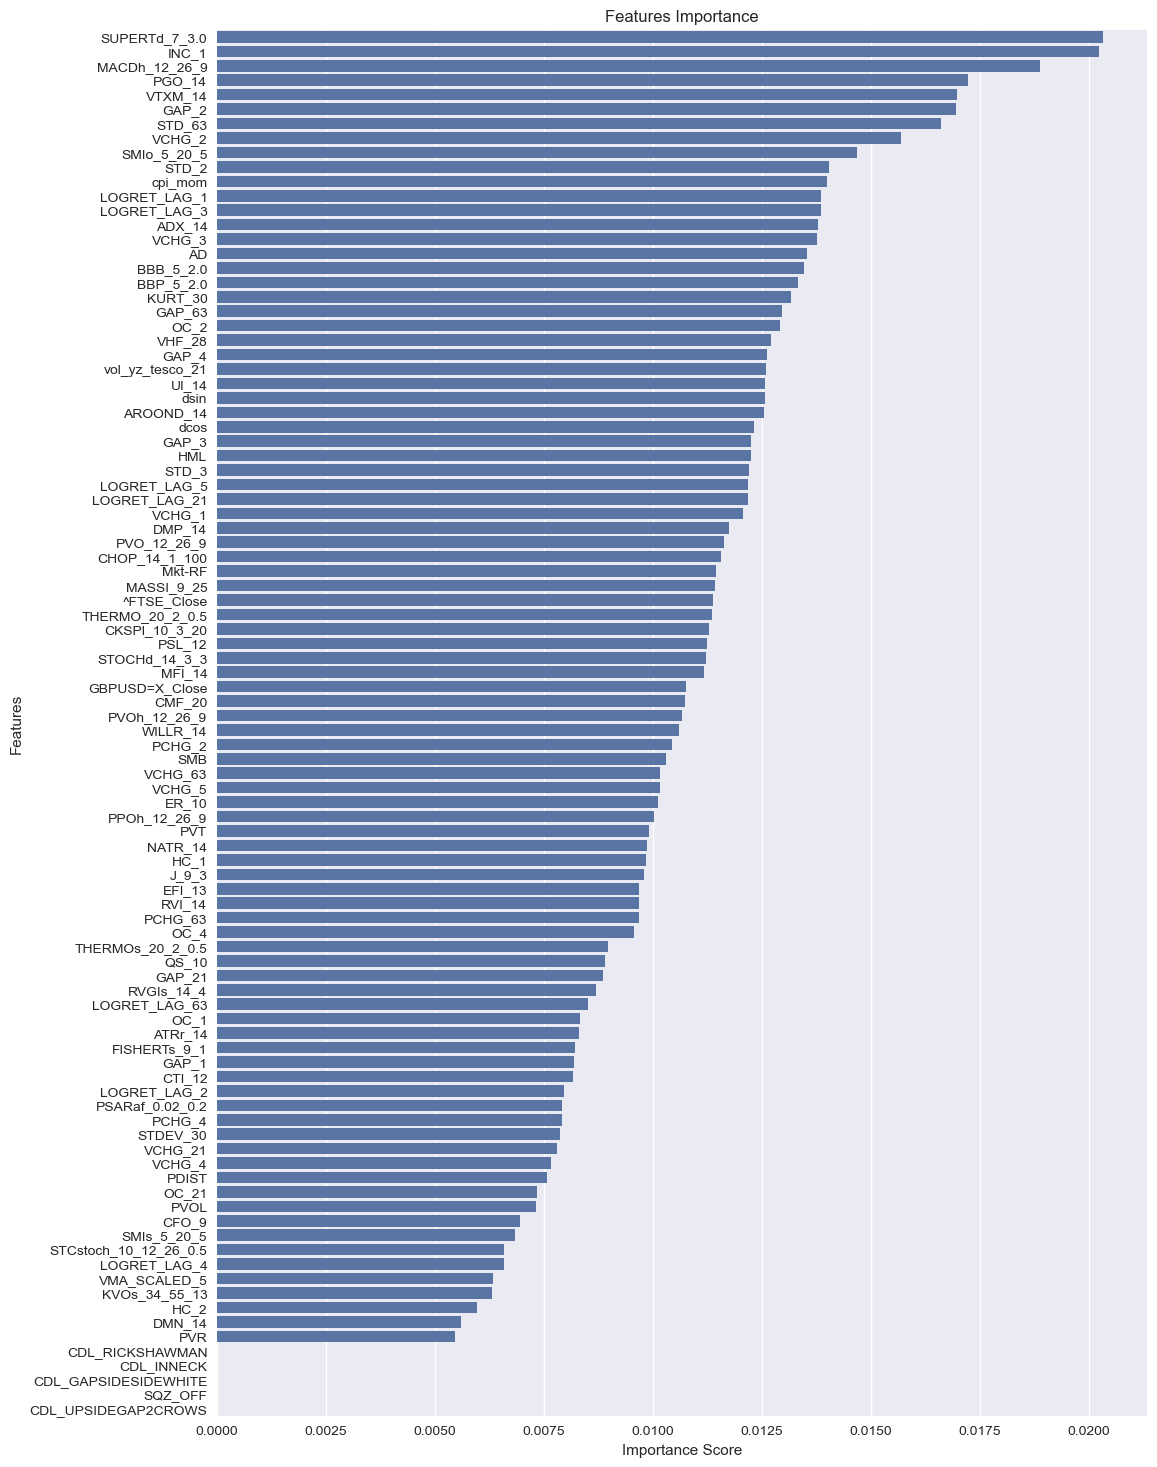

In [6]:
# Create plot for feature importance in XGBoost model training in descending order
fig, ax = plt.subplots(figsize=(12,18))
feature_imp_xg = pd.DataFrame({'Importance Score': xg_model.feature_importances_,'Features': X_train_df_scaled_kmeans_som.columns}).sort_values(by='Importance Score', ascending=False)
feature_imp_xg = feature_imp_xg[feature_imp_xg['Importance Score']>=0.00]
sns.barplot(x=feature_imp_xg['Importance Score'], y=feature_imp_xg['Features'])
ax.set_title('Features Importance');

#### XGBoost: SHAP analysis


Mean absolute SHAP values in descending order:

RVI_14:   0.24962440133094788
VCHG_2:   0.24584630131721497
CKSPl_10_3_20:   0.24478667974472046
AD:   0.21477100253105164
GAP_3:   0.21414227783679962
GAP_4:   0.2039402574300766
GBPUSD=X_Close:   0.20051532983779907
QS_10:   0.18886765837669373
CMF_20:   0.18575036525726318
LOGRET_LAG_3:   0.17423000931739807
THERMO_20_2_0.5:   0.15858939290046692
VCHG_63:   0.15783283114433289
LOGRET_LAG_1:   0.15658600628376007
KURT_30:   0.15038076043128967
VTXM_14:   0.15013612806797028
J_9_3:   0.14798377454280853
OC_1:   0.14498943090438843
LOGRET_LAG_21:   0.14420562982559204
PCHG_63:   0.1426142156124115
PVO_12_26_9:   0.139776811003685
OC_4:   0.1385251134634018
HC_2:   0.1375286877155304
EFI_13:   0.13714919984340668
ATRr_14:   0.13568413257598877
dsin:   0.1340053379535675
^FTSE_Close:   0.12913824617862701
HML:   0.12469030171632767
STD_3:   0.11819569021463394
KVOs_34_55_13:   0.11558866500854492
PVOL:   0.11531539261341095
SMB:   0.114004

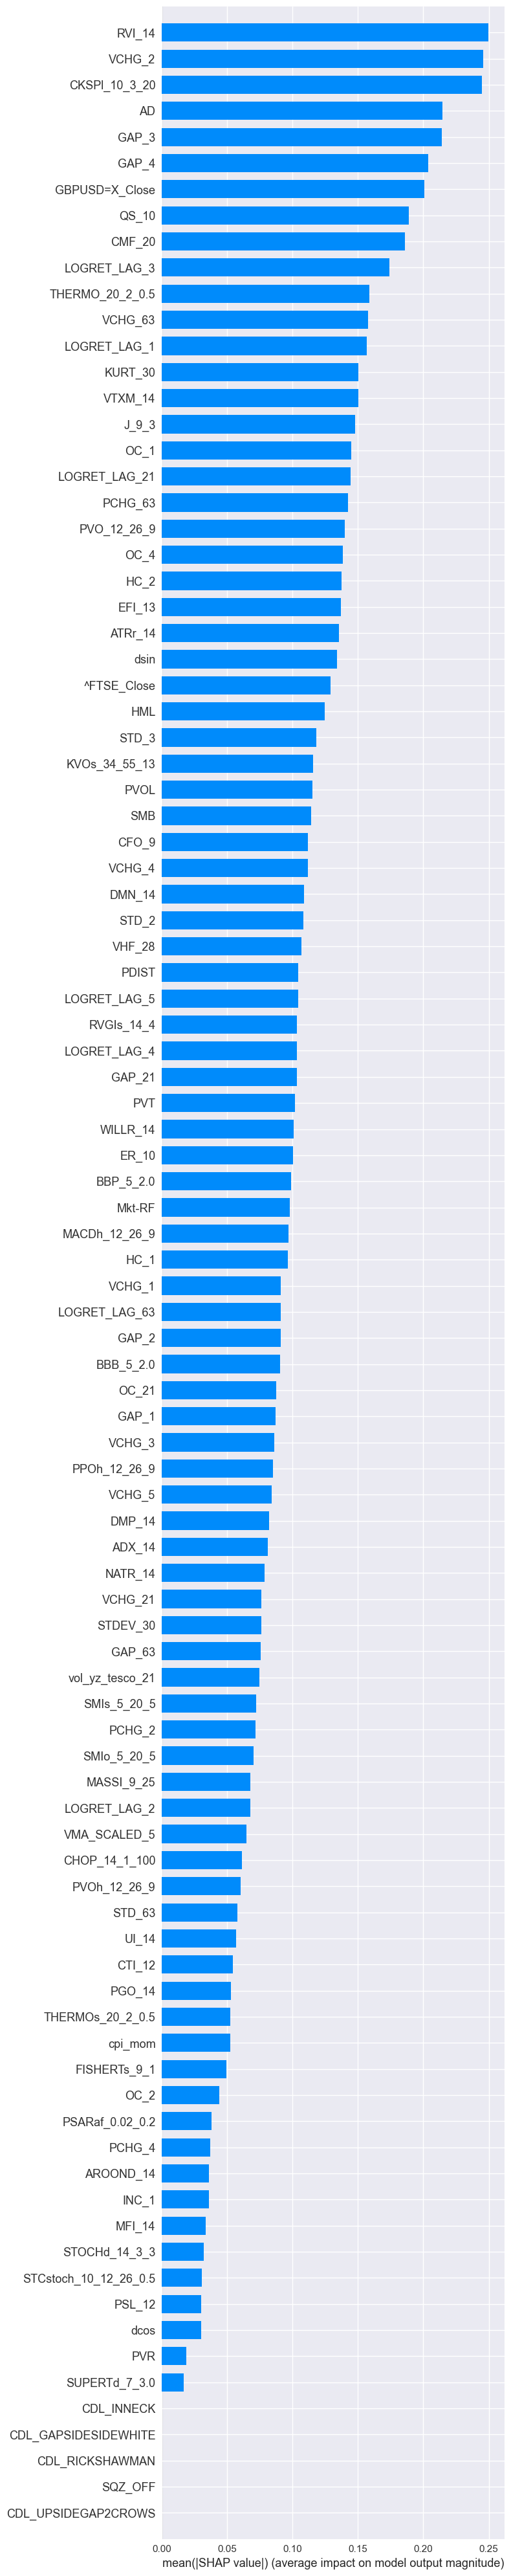

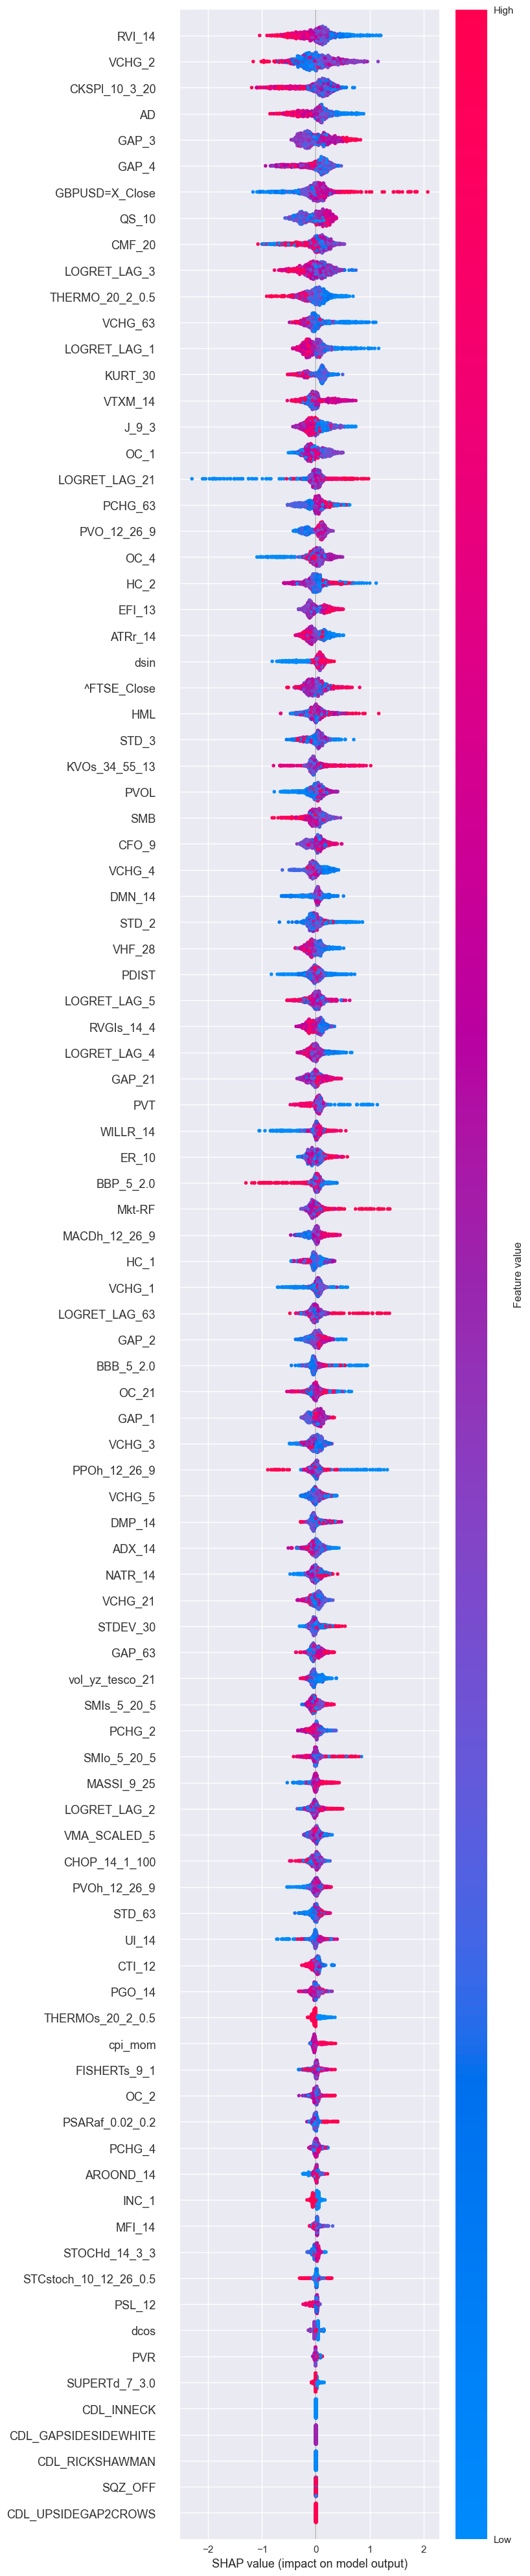

In [7]:
# Create SHAP explainer for xg_model
explainer_xg = shap.TreeExplainer(xg_model)

# Get shap values
shap_values_xg = explainer_xg.shap_values(X_train_xg)

# Get absolute SHAP values for each feature
abs_shap_values = np.abs(shap_values_xg)

# Mean absolute SHAP values across the dataset
mean_abs_shap_values = np.mean(abs_shap_values, axis=0)

# Sort features by SHAP values in descending order
sorted_features = [feature for shap, feature in sorted(zip(mean_abs_shap_values, X_train_df_scaled_kmeans_som.columns), reverse=True)]

# Display results: each features and their mean absolute SHAP values
print('''
Mean absolute SHAP values in descending order:
''' )
for feature in sorted_features:
    print(f"{feature}:   {mean_abs_shap_values[X_train_df_scaled_kmeans_som.columns.get_loc(feature)]}")

# Display shap value plots
shap.summary_plot(shap_values_xg, X_train_xg, feature_names=X_train_df_scaled_kmeans_som.columns, plot_type='bar', max_display=100)
shap.summary_plot(shap_values_xg, X_train_xg, feature_names=X_train_df_scaled_kmeans_som.columns, max_display=100, sort=True)


In [8]:
# Manually select features to be dropped from SHAP analysis
dropped_by_shap = ['cpi_mom', 'FISHERTs_9_1', 'OC_2', 'PSARaf_0.02_0.2', 'PCHG_4', 'AROOND_14', 'INC_1', 'MFI_14', 
 'STOCHd_14_3_3', 'STCstoch_10_12_26_0.5', 'PSL_12', 'dcos', 'PVR', 'SUPERTd_7_3.0', 'SQZ_OFF', 
 'CDL_UPSIDEGAP2CROWS', 'CDL_RICKSHAWMAN', 'CDL_INNECK', 'CDL_GAPSIDESIDEWHITE', 'CFO_9', 'EFI_13', 'STD_2', 'LOGRET_LAG_5', 'GAP_21', 'GAP_1', 'VCHG_3', 'VCHG_5', 'ADX_14', 
'GAP_63', 'SMIs_5_20_5', 'SMIo_5_20_5', 'VMA_SCALED_5','CHOP_14_1_100', 'PGO_14']

# Subset features by feature importance with threshold at 0.0075
low_importance_features = feature_imp_xg[feature_imp_xg['Importance Score'] < 0.01]['Features'].tolist()

# Get only the features that are retained by both methods
kept_by_shap = [feature for feature in X_train_df_scaled_kmeans_som.columns if feature not in dropped_by_shap]
kept_by_importance = [feature for feature in X_train_df_scaled_kmeans_som.columns if feature not in low_importance_features]
kept_by_xg = [feature for feature in kept_by_shap if feature in kept_by_importance]

# View features
print(f"{len(kept_by_xg)} features selected")
print(kept_by_xg)

37 features selected
['WILLR_14', 'BBP_5_2.0', 'VCHG_2', 'STD_63', 'GAP_3', 'PCHG_2', 'CKSPl_10_3_20', 'STD_3', 'Mkt-RF', 'VHF_28', 'MACDh_12_26_9', 'VCHG_63', 'GAP_4', 'THERMO_20_2_0.5', 'PVO_12_26_9', 'KURT_30', 'LOGRET_LAG_1', 'CMF_20', 'vol_yz_tesco_21', 'UI_14', 'LOGRET_LAG_3', 'LOGRET_LAG_21', 'PPOh_12_26_9', 'PVOh_12_26_9', 'GBPUSD=X_Close', 'GAP_2', 'SMB', 'VCHG_1', 'DMP_14', '^FTSE_Close', 'VTXM_14', 'dsin', 'BBB_5_2.0', 'HML', 'ER_10', 'AD', 'MASSI_9_25']


### Create feature subset and export to csv

In [9]:
# xgBoost selected features
X_train_df_scaled_xg = X_train_df_scaled_kmeans_som[kept_by_xg]
X_dev_df_scaled_xg = X_dev_df_scaled_kmeans_som[kept_by_xg]
X_test_df_scaled_xg = X_test_df_scaled_kmeans_som[kept_by_xg]

# Export selected features as csv file
X_train_df_scaled_xg.to_csv("data/X_train_df_scaled_xg.csv")
X_dev_df_scaled_xg.to_csv("data/X_dev_df_scaled_xg.csv")
X_test_df_scaled_xg.to_csv("data/X_test_df_scaled_xg.csv")
